# Linear Regression

Unlike classification tasks where the interest was to classify the data according to a discrete set of classes (categories), in regression we are interested to get a continous value out of our model. For instance, we might want to estimate the price of a house based on some features such as number of rooms, area of the house etc. Linear regression can be considered the simplest form of regression and it is given by the following function:

$y(x,w)=w_0 \cdot x_0+w_1\cdot x_1+w_2\cdot x_2+\dotsc+w_n\cdot x_n$

The key property of this model is that it is a linear function of the parameters $w_0,w_1, w_2, \dotsc, w_n$. It is also, however, a linear function of the input variables $x_i$, and this imposes significant limitations on the model. In the following tutorial we will investigate using a linear regressor of a single variable $x$ to predict the house prices using the well-known Boston house prices dataset. In fact, in this dataset many features are contributing to the house prices, but for simplicity we will choose one variable at time and investigate how the slope and the intercept are changing in order to minimise the cost.

Please refer to your lecture notes for more information on Linear regression.

In [ ]:
# import the necessary packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# load the data and print description about them
boston = load_boston()
print(boston['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [ ]:
# print feature names used in the data
boston.feature_names

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

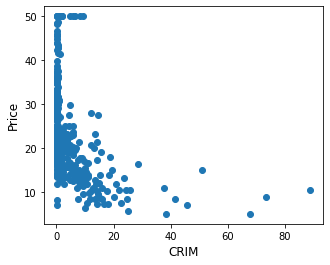

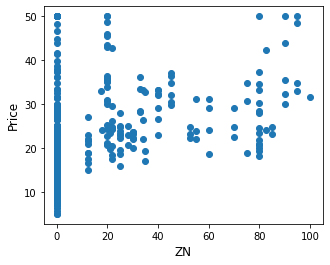

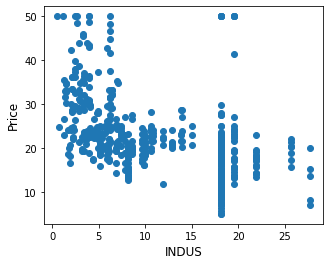

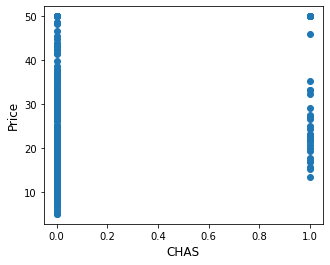

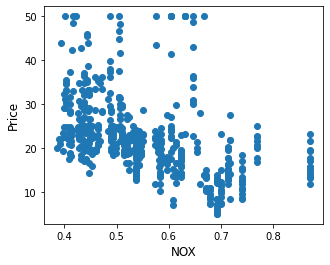

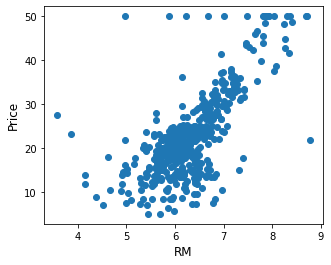

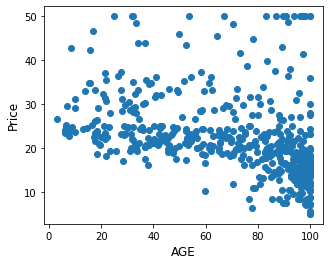

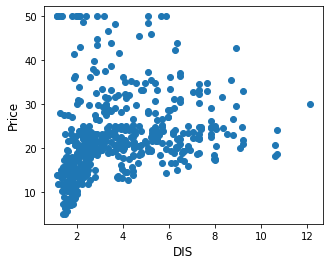

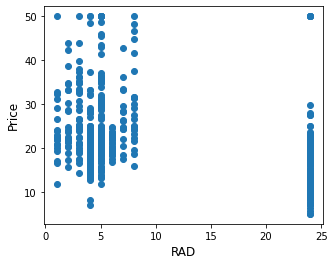

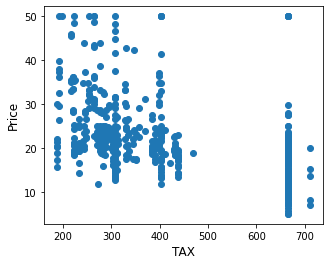

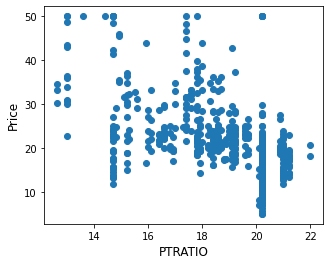

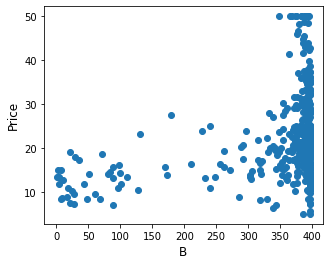

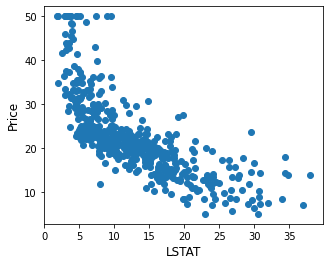

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


In [ ]:
# the following code shows the relation between house prices (output) and each feature used.

for index, feature_name in enumerate(boston.feature_names):
    plt.figure(figsize=(5, 4))
    plt.scatter(boston.data[:, index], boston.target)
    plt.ylabel('Price', size=12)
    plt.xlabel(feature_name, size=12)
    plt.show()
    
boston_data = pd.DataFrame(data=boston['data'],columns=boston['feature_names'])
boston_data["MEDV"] = boston['target']
boston_data

We will attempt the linear regression problem using Gradient Descent (GD) method and you will need to compare the results with the closed form solution as specified in Task 1.

In [ ]:
# function to perform the prediction by multiplying the inputs with weights
def predictPrice(X,W):
    return np.dot(X,W)

In [ ]:
# function to calculate the cost (here we use MSE)
def calculateCost(X,W,Y):
    prediction = predictPrice(X,W)
    return ((Y - prediction)**2).mean()/2

In [ ]:
# function to plot the predicted line vs real data
def plot_line(X,W,Y):
    """Plot a line from slope and intercept"""
    y_vals = predictPrice(X,W)
    plt.xlabel('average number of rooms per dwelling (RM)')
    plt.ylabel('Price of house (MEDV)')
    plt.scatter(X[:,1],Y, color='red', label='Actual')
    plt.plot(X[:,1], y_vals, color='black', label='Predicted')
    plt.legend(loc='upper left')
    plt.show()

In [ ]:
# function to plot cost variations as the algorithm iterate 
def plot_cost(cost):
    plt.plot(range(1, len(cost) + 1), cost)
    plt.xlabel('Iterations')
    plt.ylabel('Cost')
    plt.show()

In [ ]:
# function that applies GD and fit the algorithm
def fit(n_iter,X,Y):
    W0 = []
    W1 = []
    costs = []
    N = len(boston['target'])
    W = np.zeros(2)
    c = 0
    for i in range(n_iter):
        pred = predictPrice(X,W)
        W[0] += (2/N) *(Y - pred).mean()                     #bias
        W[1] += (2/N) *((Y - pred)* X[:,1]).mean()           #weight
        W = np.array([W[0],W[1]])
        J = calculateCost(X,W,Y)
        W0.append(W[0])
        W1.append(W[1])
        costs.append(J)
        c = i + 1
        if i%1000==0:
            print(f"Iteration: {i}, Cost = {J}, Weights = {W}")
            plot_line(X,W,Y)
    print(f"Iteration: {c}, Cost = {J}, Weights = {W}")
    plot_line(X,W,Y)
    plot_cost(costs)

In [ ]:
# call tha fit function and display the results
n_iter=150000
x = boston_data["RM"]
X = np.column_stack((np.ones(len(x)),x))
Y = boston_data["MEDV"]
fit(n_iter,X,Y)

Output hidden; open in https://colab.research.google.com to view.

# Coursework:

## Task 1:

- As you noticed, GD approach was used for optimisation. Use the closed form solution (from week 1) in solving the previous problem. In your report:

     -  Include the code you used for the closed form.

     - Compare the final weights you achived from the GD with your results in closed form solution and include that in your report. 
     
     - Include the plot showing the line produced from the closed form solution with respect to the original data as in the previous example.
     
     - Hint: have a look on the following function numpy.linalg.pinv on Numpy that can compute the (Moore-Penrose) pseudo-inverse of a matrix

- Modify the code to predict the price of house (MEDV) vs NOX concentration  and price of house (MEDV) vs % lower status of the population (LSTAT) and do the same steps as before.

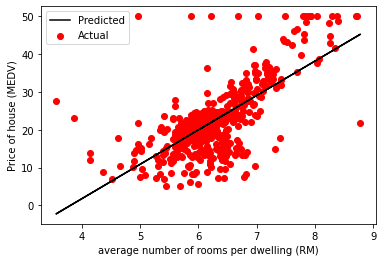

Weights = [[-34.67062078]
 [  9.10210898]]


In [ ]:
# function that applies the closed form solution
def fit_cf(X,Y):
  w = np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, Y)) # closed form solution equation
  return w

Y = np.asarray(boston_data["MEDV"])
Y = Y.reshape(-1,1)
w = fit_cf(X,Y)
plot_line(X,w,Y)
print(f"Weights = {w}")

In [ ]:
# MDEV vs NOX GD
def plot_line(X,W,Y):
    """Plot a line from slope and intercept"""
    y_vals = predictPrice(X,W)
    plt.xlabel('nitric oxides concentration (NOX)')
    plt.ylabel('Price of house (MEDV)')
    plt.scatter(X[:,1],Y, color='green', label='Actual')
    plt.plot(X[:,1], y_vals, color='black', label='Predicted')
    plt.legend(loc='upper left')
    plt.show()

def plot_cost(cost):
    plt.plot(range(1, len(cost) + 1), cost)
    plt.xlabel('Iterations')
    plt.ylabel('Cost')
    plt.show()

def fit(n_iter,X,Y):
    W0 = []
    W1 = []
    costs = []
    N = len(boston['target'])
    W = np.zeros(2)
    c = 0
    for i in range(n_iter):
        pred = predictPrice(X,W)
        W[0] += (2/N) *(Y - pred).mean()
        W[1] += (2/N) *((Y - pred)* X[:,1]).mean()
        W = np.array([W[0],W[1]])
        J = calculateCost(X,W,Y)
        W0.append(W[0])
        W1.append(W[1])
        costs.append(J)
        c = i + 1
        if i%1000==0:
            print(f"Iteration: {i}, Cost = {J}, Weights = {W}")
            plot_line(X,W,Y)
    print(f"Iteration: {c}, Cost = {J}, Weights = {W}")
    plot_line(X,W,Y)
    plot_cost(costs)

n_iter=150000
x = boston_data["NOX"]
X = np.column_stack((np.ones(len(x)),x))
Y = boston_data["MEDV"]
fit(n_iter,X,Y)

Output hidden; open in https://colab.research.google.com to view.

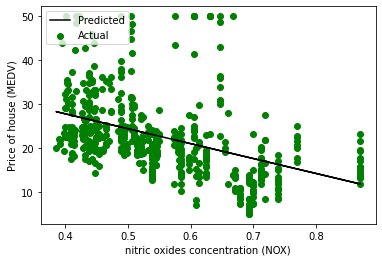

Weights = [[ 41.34587447]
 [-33.91605501]]


In [ ]:
# MDEV vs NOX closed form
def fit_cf(X,Y):
  w = np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, Y)) # closed form solution equation
  return w

Y = np.asarray(boston_data["MEDV"])
Y = Y.reshape(-1,1)
w = fit_cf(X,Y)
plot_line(X,w,Y)
print(f"Weights = {w}")

In [ ]:
# MDEV vs LSTAT GD
def plot_line(X,W,Y):
    """Plot a line from slope and intercept"""
    y_vals = predictPrice(X,W)
    plt.xlabel('% lower status of the population (LSTAT)')
    plt.ylabel('Price of house (MEDV)')
    plt.scatter(X[:,1],Y, color='purple', label='Actual')
    plt.plot(X[:,1], y_vals, color='black', label='Predicted')
    plt.legend(loc='upper left')
    plt.show()

def plot_cost(cost):
    plt.plot(range(1, len(cost) + 1), cost)
    plt.xlabel('Iterations')
    plt.ylabel('Cost')
    plt.show()

def fit(n_iter,X,Y):
    W0 = []
    W1 = []
    costs = []
    N = len(boston['target'])
    W = np.zeros(2)
    c = 0
    for i in range(n_iter):
        pred = predictPrice(X,W)
        W[0] += (2/N) *(Y - pred).mean()
        W[1] += (2/N) *((Y - pred)* X[:,1]).mean()
        W = np.array([W[0],W[1]])
        J = calculateCost(X,W,Y)
        W0.append(W[0])
        W1.append(W[1])
        costs.append(J)
        c = i + 1
        if i%1000==0:
            print(f"Iteration: {i}, Cost = {J}, Weights = {W}")
            plot_line(X,W,Y)
    print(f"Iteration: {c}, Cost = {J}, Weights = {W}")
    plot_line(X,W,Y)
    plot_cost(costs)

n_iter=150000
x = boston_data["LSTAT"]
X = np.column_stack((np.ones(len(x)),x))
Y = boston_data["MEDV"]
fit(n_iter,X,Y)

Output hidden; open in https://colab.research.google.com to view.

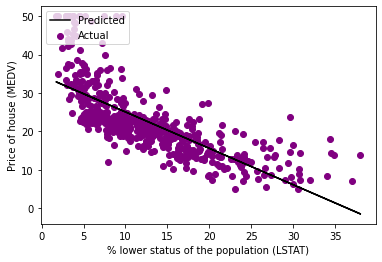

Weights = [[34.55384088]
 [-0.95004935]]


In [ ]:
# MDEV vs LSTAT closed form
def fit_cf(X,Y):
  w = np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, Y)) # closed form solution equation
  return w

Y = np.asarray(boston_data["MEDV"])
Y = Y.reshape(-1,1)
w = fit_cf(X,Y)
plot_line(X,w,Y)
print(f"Weights = {w}")

## Task 2:

- Rewrite the code using scikit-learn package for MEDV vs each feature used previousely (RM, NOX, LSTAT) (More information can be found here: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html). In your report:

    - Include the code you used.
    - Compare the final weights obtained in Task 1 with what weights obtained using scikit-learn package. Hint: check the methods $.coef_$ and $.intercept_$ for obtaining the slope and intercept in scikit-learn linear regressor.

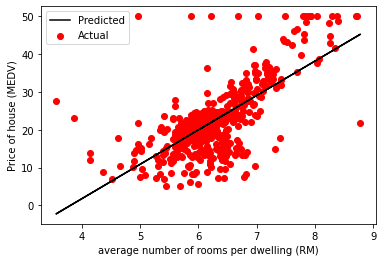

Weights = [array([-34.67062078]) 9.10210898118031]


In [ ]:
# MDEV vs RM
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X, Y)
w = np.asarray([reg.intercept_, reg.coef_[0,1]]) #express w in the form of y=ax+b where a is the slope and b is the intercept
plot_line(X,w,Y)
print(f"Weights = {w}")

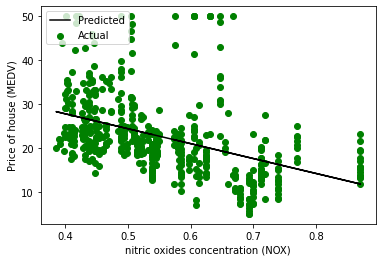

Weights = [array([41.34587447]) -33.9160550086611]


In [ ]:
# MDEV vs NOX
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X, Y)
w = np.asarray([reg.intercept_, reg.coef_[0,1]]) #express w in the form of y=ax+b where a is the slope and b is the intercept
plot_line(X,w,Y)
print(f"Weights = {w}")


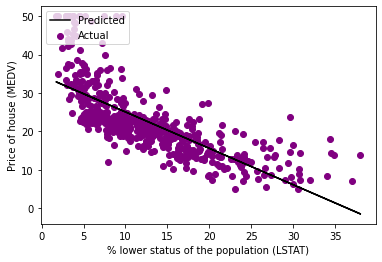

Weights = [array([34.55384088]) -0.9500493537579912]


In [ ]:
# MDEV vs LSTAT
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X, Y)
w = np.asarray([reg.intercept_, reg.coef_[0,1]]) #express w in the form of y=ax+b where a is the slope and b is the intercept
plot_line(X,w,Y)
print(f"Weights = {w}")


## Task 3 (Optional):

Use all the 13 features in the data as inputs to the regressor in order to predict the price (MEDV). Compare the results you get (in terms of the RMSE) to that when you use single variable at a time.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

boston = load_boston()
boston_data = pd.DataFrame(data=boston['data'],columns=boston['feature_names'])
boston_data["MEDV"] = boston['target']

X = np.column_stack((boston_data["CRIM"],boston_data["ZN"],boston_data["INDUS"],boston_data["CHAS"], boston_data["NOX"], boston_data["RM"], boston_data["AGE"], boston_data["DIS"], boston_data["RAD"], boston_data["TAX"], boston_data["PTRATIO"], boston_data["B"], boston_data["LSTAT"]))


Y = boston_data["MEDV"]

reg = LinearRegression().fit(X, Y)
print(reg.intercept_)
print(reg.coef_) 

features = boston.data.T
Z=features
ZT=np.transpose(Z)
X_train, X_test, y_train, y_test = train_test_split(ZT, boston.target, test_size=0.2, random_state=0)
lr = LinearRegression()
lr.fit(X_train, y_train)
y_tr_pred = lr.predict(X_train)
y_te_pred = lr.predict(X_test)
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_te_pred)))

36.459488385090125
[-1.08011358e-01  4.64204584e-02  2.05586264e-02  2.68673382e+00
 -1.77666112e+01  3.80986521e+00  6.92224640e-04 -1.47556685e+00
  3.06049479e-01 -1.23345939e-02 -9.52747232e-01  9.31168327e-03
 -5.24758378e-01]
Root Mean Squared Error: 5.783509315085133
